In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
# Load imbalnaced data into a Pandas Dataframe
df = pd.read_csv('indian_liver_patient.csv')


In [2]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


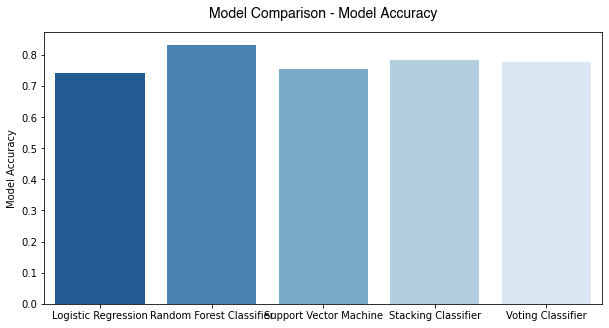


Confusion Matrix for Stacking Classifier:
[[61 14]
 [22 70]]

Classification Report for Stacking Classifier:
              precision    recall  f1-score   support

           1       0.73      0.81      0.77        75
           2       0.83      0.76      0.80        92

    accuracy                           0.78       167
   macro avg       0.78      0.79      0.78       167
weighted avg       0.79      0.78      0.78       167


Confusion Matrix for Voting Classifier:
[[50 25]
 [12 80]]

Classification Report for Voting Classifier:
              precision    recall  f1-score   support

           1       0.81      0.67      0.73        75
           2       0.76      0.87      0.81        92

    accuracy                           0.78       167
   macro avg       0.78      0.77      0.77       167
weighted avg       0.78      0.78      0.78       167



['liver_model.sav']

In [4]:
from sklearn.preprocessing import LabelEncoder
# Assuming 'data' is the DataFrame
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import joblib


# Assuming 'Dataset' is the target variable
X = df.drop("Dataset", axis=1)
y = df["Dataset"]

# Mapping numeric values for Gender (assuming 'Gender' is a binary variable)
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 2})

# Filling missing values with the median
X.fillna(X.median(), inplace=True)

# Handle class imbalance
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Splitting the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)

# Random Forest Classifier - Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_rfc = grid_search.best_estimator_
best_rfc_score = best_rfc.score(X_test, y_test)

# Support Vector Machine (SVM)
svm = SVC(class_weight='balanced', probability=True)
svm.fit(X_train, y_train)
svm_score = svm.score(X_test, y_test)

# Stacking Classifier
estimators = [
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000)),
    ('best_rfc', best_rfc),
    ('svm', SVC(class_weight='balanced', probability=True))
]

# Volting Classifier
stacking_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())
stacking_model.fit(X_train, y_train)
stacking_score = stacking_model.score(X_test, y_test)

# Model Comparison
voting_model = VotingClassifier(estimators=estimators, voting='hard')
voting_model.fit(X_train, y_train)
voting_score = voting_model.score(X_test, y_test)

model_names = ["Logistic Regression", "Random Forest Classifier", "Support Vector Machine", "Stacking Classifier", "Voting Classifier"]
model_scores = [lr_score, best_rfc_score, svm_score, stacking_score, voting_score]

plt.figure(figsize=(10, 5))
sns.barplot(x=model_names, y=model_scores, palette="Blues_r")
plt.ylabel("Model Accuracy")
plt.title("Model Comparison - Model Accuracy", fontsize=14, fontname="Helvetica", y=1.03)
plt.show()

# COnfusion Matrix and Classification Report for Stacking Classifier
y_pred_stacking = stacking_model.predict(X_test)
cf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
print("\nConfusion Matrix for Stacking Classifier:")
print(cf_matrix_stacking)
print("\nClassification Report for Stacking Classifier:")
print(classification_report(y_test, y_pred_stacking))

# Confusion Matrix and Classification Report for Voting Classifier
y_pred_voting = voting_model.predict(X_test)
cf_matrix_voting = confusion_matrix(y_test, y_pred_voting)
print("\nConfusion Matrix for Voting Classifier:")
print(cf_matrix_voting)
print("\nClassification Report for Voting Classifier:")
print(classification_report(y_test, y_pred_voting))

# Save the best model
joblib.dump(voting_model, 'liver_model.sav')